<a href="https://colab.research.google.com/github/Anthony5234534/STAT3011-Project-II/blob/main/Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This note book is based on [Chapter 40 : Determining Your Most Valuable Customers from “Data Science, Analytics, and AI for Business and the Real World”](https://github.com/PacktPublishing/Data-Science-Analytics-AI-for-Business-the-Real-World-/blob/29b55b97f2151620b7ce9ac207b12db14c67d0d5/All%20Resource%20files/Case%20Studies/Customer%20Lifetime%20Value.ipynb), suggests alternative methods and proposes improvements.

## Problem statement
This project aims to identify high-value customers by predicting their Customer Lifetime Value (CLV) for the next 3 months. The CLV of each customer is defined as their total transaction amount during that period. Using past transaction data from December, 2010, to December, 2011, models are built to predict the total transaction amount for the next 3 months.

## Customer lifetime value definition
Customer lifetime value (CLV) is a metric used to estimate the total amount of money a customer is expected to spend on your products and services throughout their lifetime as a customer, based on their Monetary Value, Purchasing Frequency, and Recency. It is a prognostication of the net profit contributed to the whole future relationship with a customer. The higher the CLV, the more valuable is the buyer for businesses, as more revenue or profit is produced and is likely to remain loyal.

In this project, the method of calculating the CLV for each customer is based on finding their total transaction amount within a specific period of time.

## The RFM (Recency, Frequency, Monetary) analysis
Recency, frequency, and monetary value are used to predict CLV.

1. Recency

  - Definition: The time intervals between purchases.

  - Measurement: Typically calculated the average days from the most recent transaction date to the analysis date.

  - Importance: Recent customers are more likely to engage again, making them prime targets for marketing. Moreover, low recency correlates with higher customer retention.

2. Purchase frequency

  - Definition: How often a customer makes purchases within a given period.

  - Measurement: The total number of transactions in a timeframe.

  - Importance: It indicates loyalty and engagement, which means frequent buyers are more likely to respond to promotions. Besides, it helps identify at-risk customers if the frequency drops.

  - Considerations: However, high frequency does not always mean satisfaction. Low-frequency buyers might still have high monetary value, such as buying luxury goods.

     
3. Monetary value
  - Definition: The total amount a customer has spent over a specific period. It reflects their financial contribution to the business.

  - Measurement: Calculated as the sum of all purchases within a defined timeframe.

  - Importance: It can help identify high-spending customers who contribute significantly to revenue. Therefore, we can prioritize retention efforts for top spenders.



## Approaches to the problem of orinigal solution
1. Data Preparation
   - Import retail transaction data
   - Data cleaning
   - Create summary statistics of the data set
   - Filter transactions
   - Data Visualization

2. Feature Engineering
   - Calculate sales revenue (Quantity × UnitPrice)
   - Create the sale sum, sale avg, sale count of each transaction intervals M

3. Predictive Modeling
   - Create 3-month transaction intervals
   - Build features from historical windows (M2-M5)
   - Use Linear Regression to predict 3-month CLV
   - Use actual vs predicted scatter plots to determine whether the model is well fit

## Approaches to the problem of extension solution
1. Proposed BG/NBD with gamma gamma model instead of linear regression to predict future 3 month CLV
2. Used k mean cluster to identify high-value customer using the future 3 month CLV

**Further details are provided in the corresponding section.**


# Orinigal Solution

In [ ]:
# This code is to import necessary Python libraries and modules used in the origal solution

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Our data set is store in the "df" variable

file_name = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/OnlineRetail.xlsx"
df = pd.read_excel(file_name, sheet_name='Online Retail')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Data date range
print('Date Range: %s to %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max()))

Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [ ]:
# Check for null values in each column
null_counts = df.isnull().sum()
print("Null values per column:")
print(null_counts)

# Check for negative values in each numeric column
negatives = df.select_dtypes(include=['number']) < 0
negative_counts = negatives.sum()
print("\nNegative values per numeric column:")
print(negative_counts)

Null values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Negative values per numeric column:
Quantity      10624
UnitPrice         2
CustomerID        0
dtype: int64


**Note**
There are some null values in the variable CustomerID and negative value in `Quantity`, we would like to remove those.

In [ ]:
# Data cleaning
# Remove those null value in customerID and negative value in Quantity
# And finally our data date range will change from 2010-12-01 to 2011-11-30

df = df.loc[df['Quantity'] > 0] # Remove quantities that are less than 0 (possibly returned items)
df = df[pd.notnull(df['CustomerID'])] # Remove blank customer IDs
df = df.loc[df['InvoiceDate'] < '2011-12-01'] # taking all of the transactions that occurred before December 01, 2011

In [ ]:
# Check the df again
# Check for null values in each column
null_counts = df.isnull().sum()
print("Null values per column:")
print(null_counts)

# Check for negative values in each numeric column
negatives = df.select_dtypes(include=['number']) < 0
negative_counts = negatives.sum()
print("\nNegative values per numeric column:")
print(negative_counts)

Null values per column:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Negative values per numeric column:
Quantity      0
UnitPrice     0
CustomerID    0
dtype: int64


**Note**:
Now no variable column have negative and null value.

In [ ]:
# Get a orders summary dataset that shows the total in sales made per customer invoice

df['Sales'] = df['Quantity'] * df['UnitPrice'] # Create a Sales Revenue Column

orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({'Sales': sum,'InvoiceDate': max})
orders_df.head(10)

<ipython-input-7-1c734840c5c8>:5: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({'Sales': sum,'InvoiceDate': max})
<ipython-input-7-1c734840c5c8>:5: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({'Sales': sum,'InvoiceDate': max})


Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00
           562032       584.91 2011-08-02 08:48:00
           573511      1294.32 2011-10-31 12:25:00
12348.0    539318       892.80 2010-12-16 19:09:00
           541998       227.44 2011-01-25 10:42:00
           548955       367.00 2011-04-05 10:47:00

In [ ]:
# create our summary by each custome dataframe

def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

summary_df = orders_df.reset_index().groupby('CustomerID').agg({
    'Sales': [min, max, sum, groupby_mean, groupby_count],
    'InvoiceDate': [min, max, purchase_duration, avg_frequency]
})
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]
summary_df.head(10)

<ipython-input-8-ca4accc126db>:21: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  summary_df = orders_df.reset_index().groupby('CustomerID').agg({
<ipython-input-8-ca4accc126db>:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  summary_df = orders_df.reset_index().groupby('CustomerID').agg({
<ipython-input-8-ca4accc126db>:21: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  summary_df = orders_df.reset_index().groupby('CustomerID').agg({


,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
CustomerID,,,,,,,,,
12346.0,77183.60,77183.60,77183.60,77183.600000,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.000000
12347.0,382.52,1294.32,4085.18,680.863333,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.500000
12348.0,227.44,892.80,1797.24,449.310000,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.500000
12349.0,1757.55,1757.55,1757.55,1757.550000,1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.000000
12350.0,334.40,334.40,334.40,334.400000,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.000000
12352.0,120.33,840.30,2506.04,313.255000,8,2011-02-16 12:33:00,2011-11-03 14:37:00,260,32.500000
12353.0,89.00,89.00,89.00,89.000000,1,2011-05-19 17:47:00,2011-05-19 17:47:00,0,0.000000
12354.0,1079.40,1079.40,1079.40,1079.400000,1,2011-04-21 13:11:00,2011-04-21 13:11:00,0,0.000000
12355.0,459.40,459.40,459.40,459.400000,1,2011-05-09 13:49:00,2011-05-09 13:49:00,0,0.000000


## Visualization

In [ ]:
# Let's look at the first 20 sales counts and the average spend for that sale

# We firstly group by Sales_Counts and then look at the sales_avg
summary_df.groupby('sales_count').count()['sales_avg'][:20]

,sales_avg
sales_count,
1,1539
2,806
3,515
4,381
5,228
6,172
7,132
8,97
9,60


In [ ]:
# Remove those customer have only one sale count
# Purchase durations that are equal to 0 indicate that only purchase was ever made.
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]
summary_df

,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
CustomerID,,,,,,,,,
12347.0,382.52,1294.32,4085.18,680.863333,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.500000
12348.0,227.44,892.80,1797.24,449.310000,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.500000
12352.0,120.33,840.30,2506.04,313.255000,8,2011-02-16 12:33:00,2011-11-03 14:37:00,260,32.500000
12356.0,58.35,2271.62,2811.43,937.143333,3,2011-01-18 09:50:00,2011-11-17 08:40:00,302,100.666667
12359.0,547.50,2876.85,6372.58,1593.145000,4,2011-01-12 12:43:00,2011-10-13 12:47:00,274,68.500000
...,...,...,...,...,...,...,...,...,...
18270.0,111.95,171.20,283.15,141.575000,2,2011-03-18 12:41:00,2011-11-01 13:57:00,228,114.000000
18272.0,340.72,753.66,2710.70,542.140000,5,2011-04-07 09:35:00,2011-10-25 11:52:00,201,40.200000
18273.0,51.00,102.00,153.00,76.500000,2,2011-03-27 11:22:00,2011-09-05 11:27:00,162,81.000000


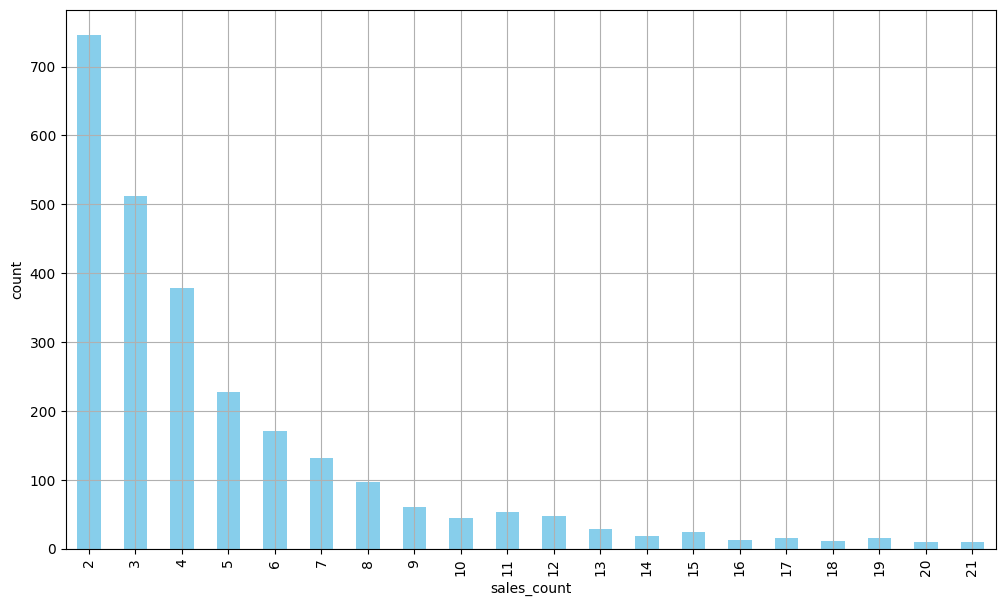

In [ ]:
# We filter on invoicedate_purchase_duration greater than 0
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]

ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(kind='bar', color='skyblue',figsize=(12,7), grid=True)

ax.set_ylabel('count')

plt.show()

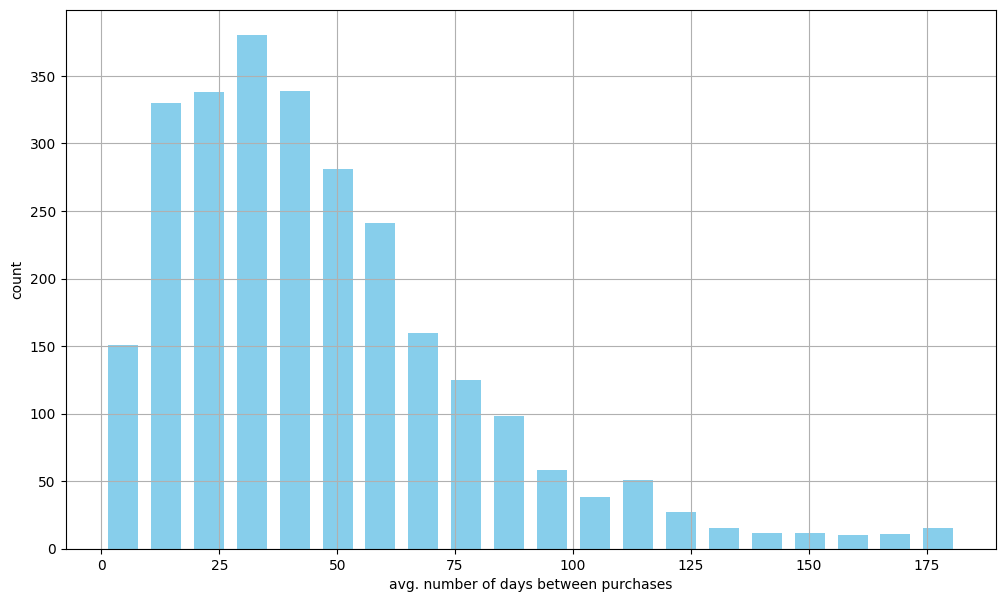

In [ ]:
# Now we create a distribution for the average times between sales
ax = summary_df['invoicedate_purchase_frequency'].hist(bins=20, color='skyblue', rwidth=0.7, figsize=(12,7))

ax.set_xlabel('avg. number of days between purchases')
ax.set_ylabel('count')

plt.show()

## Predicting the 3 month Customer Lifetime Value

In [ ]:
orders_df.head()

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00

In [ ]:
# Create summary statistics in 3 month intervals for customer Sales

# Use 3M for 3 month
clv_freq = '3M'

# Groupby customer ID now, and group all invoices for 3 month cycles.
# Aggregate on sum, mean and counts
data_df = orders_df.reset_index().groupby(['CustomerID', pd.Grouper(key='InvoiceDate', freq=clv_freq)]).agg({
    'Sales': [sum, groupby_mean, groupby_count],})

data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
data_df = data_df.reset_index()
data_df.head()

<ipython-input-14-21b01ef552db>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_df = orders_df.reset_index().groupby(['CustomerID', pd.Grouper(key='InvoiceDate', freq=clv_freq)]).agg({
<ipython-input-14-21b01ef552db>:8: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data_df = orders_df.reset_index().groupby(['CustomerID', pd.Grouper(key='InvoiceDate', freq=clv_freq)]).agg({


,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2011-03-31,77183.60,77183.600,1
1,12347.0,2010-12-31,711.79,711.790,1
2,12347.0,2011-03-31,475.39,475.390,1
3,12347.0,2011-06-30,1018.77,509.385,2
4,12347.0,2011-09-30,584.91,584.910,1


In [ ]:
# Adding Recency 'M'

# Get the M
date_month_map = {str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True))}

# Create our M Column
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:10]])
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.600,1,M_4
1,12347.0,2010-12-31,711.79,711.790,1,M_5
2,12347.0,2011-03-31,475.39,475.390,1,M_4
3,12347.0,2011-06-30,1018.77,509.385,2,M_3
4,12347.0,2011-09-30,584.91,584.910,1,M_2


In [ ]:
data_df['M'].unique()

array(['M_4', 'M_5', 'M_3', 'M_2', 'M_1'], dtype=object)

In [ ]:
# Create our Features DF
features_df = pd.pivot_table(data_df.loc[data_df['M'] != 'M_1'], values=['sales_sum', 'sales_avg', 'sales_count'], columns='M', index='CustomerID')

features_df.columns = ['_'.join(col) for col in features_df.columns]

features_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,NaN,NaN,77183.600,NaN,NaN,NaN,1.0,NaN,NaN,NaN,77183.60,NaN
12347.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,NaN,NaN,334.400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,334.40,NaN
12352.0,316.25,NaN,312.362,NaN,2.0,NaN,5.0,NaN,632.50,NaN,1561.81,NaN


In [ ]:
# Create our Response DF
response_df = data_df.loc[data_df['M'] == 'M_1', ['CustomerID', 'sales_sum']]

response_df.columns = ['CustomerID', 'CLV_'+clv_freq]
response_df.head()

,CustomerID,CLV_3M
5,12347.0,1294.32
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67


In [ ]:
# Create our Sample Set by merging features with response_df
sample_set_df = features_df.merge(
    response_df,
    left_index=True,
    right_on='CustomerID',
    how='left'
)

sample_set_df = sample_set_df.fillna(0)
sample_set_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.000000,0.000,77183.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,0.00
5.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.000000,367.000,227.440000,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,0.00
NaN,0.000000,0.000,334.400000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,0.00
14.0,316.250000,0.000,312.362000,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.000000,0.000,180.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,180.60,0.00,18280.0,0.00
NaN,0.000000,80.820,0.000000,0.00,0.0,1.0,0.0,0.0,0.00,80.82,0.00,0.00,18281.0,0.00
NaN,100.210000,0.000,0.000000,0.00,1.0,0.0,0.0,0.0,100.21,0.00,0.00,0.00,18282.0,0.00
9217.0,92.696667,131.170,105.966667,0.00,3.0,4.0,3.0,0.0,278.09,524.68,317.90,0.00,18283.0,766.21


## Using Linear Regression

In [ ]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Our Target Variable
target_var = 'CLV_'+clv_freq

# Our Features
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID', target_var]]

# Split data in Train and Test
x_train, x_test, y_train, y_test = train_test_split(sample_set_df[all_features], sample_set_df[target_var], test_size=0.3, random_state=2025)

# Fit Model
reg_fit = LinearRegression()
reg_fit.fit(x_train, y_train)

LinearRegression()

In [ ]:
# Get our y intercept
reg_fit.intercept_

np.float64(24.321407732123248)

In [ ]:
# Get our coefficents
reg_fit.coef_

array([   0.27160473,   -0.78802793,    0.52097257,   -0.43046414,
        115.94173866,   30.19684353, -169.16906312,  -33.51965247,
          0.19165836,    0.40209284,    0.16927833,    0.83997347])

In [ ]:
# Show them here per feature
coef = pd.DataFrame(list(zip(all_features, reg_fit.coef_)))
coef.columns = ['feature', 'coef']

coef

,feature,coef
0,sales_avg_M_2,0.271605
1,sales_avg_M_3,-0.788028
2,sales_avg_M_4,0.520973
3,sales_avg_M_5,-0.430464
4,sales_count_M_2,115.941739
5,sales_count_M_3,30.196844
6,sales_count_M_4,-169.169063
7,sales_count_M_5,-33.519652
8,sales_sum_M_2,0.191658
9,sales_sum_M_3,0.402093


In [ ]:
# Run our input data into our model predictors
train_preds = reg_fit.predict(x_train)
test_preds = reg_fit.predict(x_test)

In [ ]:
# Assess performance Training Data
from sklearn.metrics import r2_score, median_absolute_error


print(r2_score(y_true=y_train, y_pred=train_preds))
print(median_absolute_error(y_true=y_train, y_pred=train_preds))

0.7437931800806381
227.47339303627587


In [ ]:
# Compare R-Squared Performance on Training and Test Datasets
print('In-Sample R-Squared: %0.4f' % r2_score(y_true = y_train, y_pred = train_preds))
print('Out-of-Sample R-Squared: %0.4f' % r2_score(y_true = y_test, y_pred = test_preds))

In-Sample R-Squared: 0.7438
Out-of-Sample R-Squared: -1.0251


In [ ]:
# Compare MSE and MAE on Training and Test Datasets
print('In-Sample MAE: %0.4f' % median_absolute_error(y_true = y_train, y_pred = train_preds))
print('Out-of-Sample MAE: %0.4f' % median_absolute_error(y_true = y_test, y_pred = test_preds))

In-Sample MAE: 227.4734
Out-of-Sample MAE: 228.7129


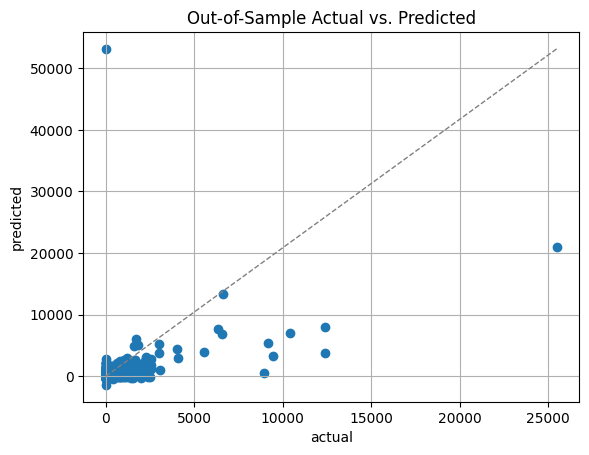

In [ ]:
# Plot the predicted vs actual values using our Test Dataset
plt.scatter(y_test, test_preds)
plt.plot([0, max(y_test)], [0, max(test_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted')
plt.grid()

plt.show()

**Graph Explanination**

The graph show 1085 data point, and the 45-degree straight line represents the ideal case that the actual values and predicted values are equal.

- ​If a data point is closer to this line, this means that the model's prediction for that point is more accurate.
- ​Points far from that line means larger prediction errors.
- For the graph above, most of the data point are close to the straight line, so the prediction accuracy of the linear model is fair. (but a few actually far away from the straight line)

## Further work: Re generate the actual - predict plot

Since there is some negative predicted CLV in the `test_preds`, which is the invaild value and the weekness of solution, so we would like to remove those negative value and generate the actual predict plot again and also calculate the Maximum absolute error.

After that, we will do the same things in our new proposed model (will discuss further) to create the actual - predict plot, then compare those graph to find which model are better in predicted accuracy.



In [ ]:
# First get the data frame "df_Y" of variable y_test and test_preds first
df_Y = pd.DataFrame({
    'y_test': y_test,
    'test_preds': test_preds
})
df_Y

,y_test,test_preds
14.0,311.73,44.591097
2937.0,902.01,410.898178
2812.0,245.05,455.053016
NaN,0.00,579.122001
NaN,0.00,185.593849
...,...,...
NaN,0.00,361.661207
5440.0,116.56,-139.823429
NaN,0.00,89.177884
7372.0,138.05,-244.478423


In [ ]:
# We notice that there is some negative CLV predicted which is not resonable, so we will remove them

df_Y = df_Y[(df_Y['test_preds'] >= 0)]
df_Y

,y_test,test_preds
14.0,311.73,44.591097
2937.0,902.01,410.898178
2812.0,245.05,455.053016
NaN,0.00,579.122001
NaN,0.00,185.593849
...,...,...
4755.0,346.80,426.387236
3143.0,109.01,306.690409
NaN,0.00,361.661207
NaN,0.00,89.177884


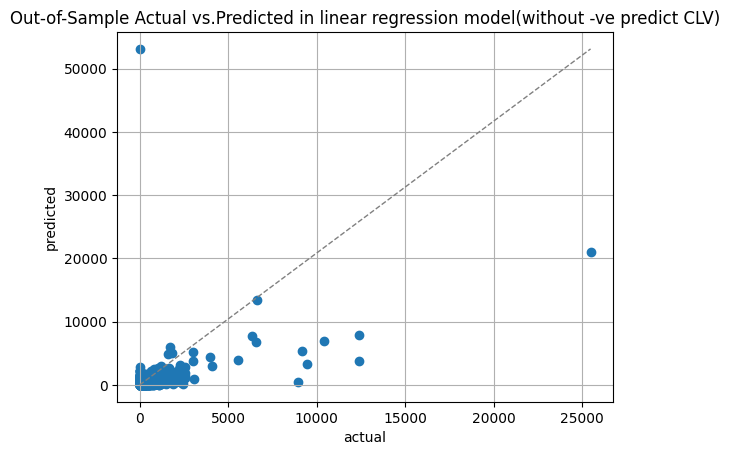

In [ ]:
plt.scatter(df_Y['y_test'], df_Y['test_preds'])
plt.plot([0, max(df_Y['y_test'])], [0,max(df_Y['test_preds'])], color='gray', lw=1, linestyle='--')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs.Predicted in linear regression model(without -ve predict CLV)')
plt.grid()

plt.show()

In [ ]:
# Calculate the out-sample after remove the negative CLV
print('Out-of-Sample MAE after removing negative predicted value: %0.4f' % median_absolute_error(y_true = df_Y['y_test'], y_pred = df_Y['test_preds']))
print('Out-of-Sample R-Squared after removing negative predicted value: %0.4f' % r2_score(y_true = df_Y['y_test'], y_pred = df_Y['test_preds']))

Out-of-Sample MAE after removing negative predicted value: 250.6356
Out-of-Sample R-Squared after removing negative predicted value: -1.0532


**Result Explanination**

Now the MAE become 250.6356, which is slighter greater than before, although the graph is similar.


**Generate the actual-predicted plot by removing those actual CLV equal 0 and log the actual predicted value again.**

We find there there is some actual CLV value is 0. Since our target is to find those actually high CLV customer, so remove those CLV=0 can compare their performance in predicting the high CLV, and since there is some outliners, we would further log the predict CLV and actual CLV and plot the graph again.

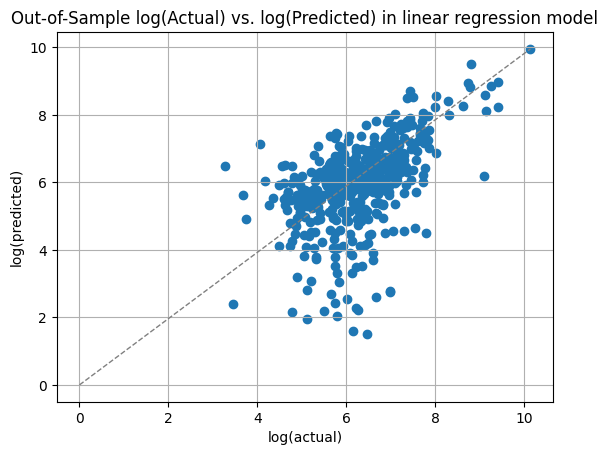

In [ ]:
df_Y_clean = df_Y

df_Y_clean = df_Y_clean[
    (df_Y_clean['y_test'] > 0) &
    (df_Y_clean['test_preds'] > 0)
]

plt.scatter(np.log(df_Y_clean['y_test']), np.log(df_Y_clean['test_preds']))
plt.plot([0, np.log(max(df_Y_clean['y_test']))], [0,max(np.log(df_Y_clean['test_preds']))], color='gray', lw=1, linestyle='--')

plt.xlabel('log(actual)')
plt.ylabel('log(predicted)')
plt.title('Out-of-Sample log(Actual) vs. log(Predicted) in linear regression model')
plt.grid()

plt.show()

In [ ]:
# Calculate the out-sample after log(CLV)
print('Out-of-Sample MAE after log(CLV): %0.4f' % median_absolute_error(y_true=np.log(df_Y_clean['y_test']),y_pred=np.log(df_Y_clean['test_preds'])))
print('Out-of-Sample R-Squared after log(CLV): %0.4f' % r2_score(y_true = np.log(df_Y_clean['y_test']), y_pred = np.log(df_Y_clean['test_preds'])))

Out-of-Sample MAE after log(CLV): 0.5542
Out-of-Sample R-Squared after log(CLV): -0.4497


**Note**

Those graph will then used to compare the corresponding actual - predicted graph of our new proposed model (BG/NBD with gamma gamma model)

## **Statistical Concept used in orinigal solution**

### 1. Time Series Analysis
 - Dividing time into 5 consecutive periods
   - M1: 30/09/2011 - 31/12/2011
   - M2: 30/06/2011 - 30/09/2011
   - M3: 31/03/2011 - 30/06/2011
   - M4: 31/12/2011 - 31/03/2011
   - M5: 30/09/2011 - 31/12/2010
 - Using data from M1 to M5 to train a machine learning model to predict customer behavior in future time periods (e.g. CLV in the next 3 months)

### 2. Recency-Frequency-Monetary(RFM)Analysis
  - Definition of RFM represents:
    - R(ecency): Recent time of purchase -> Each period
    - F(rquency): Number of purchase -> `Sales_count`
    - M(onetary Vaule): Amount of purchase -> `Sales_average` and `Sales_sum`
  - Counting slaes average, sum, and count for each period to predict customer lfetime value

### 3. Machine Learning
  - Time period of testing: M1 `CLV_3M`
  - Time period of training: From M2 to M5

    (i) The dataset is divided into a training set and a test set, with the test set accounting for 30% and the training set accounting for 70%

    (ii) Use LinearRegression to fit the training data

    (iii) Match the features and the corresponding coefficients into a DataFrame to facilitate viewing the impact of each feature on CLV

    (iv) Use the trained set to predict the test set

    (v) Use R² (coefficient of determination) and MAE (median absolute error) to evaluate the performance of the model

### 4. Model Evaluation
  - Linear regression: A statistical method used to model the linear relationship between a dependent variable (target variable) and one or more independent variables (features). The goal is to find the best fit line that minimizes the error between the predicted value and the actual value.
    - Intercept: the predicted value when all features are 0.
    - Coefficient: represents the degree of influence of each feature on the target variable.

  - R² (coefficient of determination): A measure of the proportion of the variance of the target variable explained by the model, ranging from 0 to 1. The closer it is to 1, the stronger the explanatory power of the model.

  - Median absolute error (MAE): The median of the difference between the predicted value and the actual value, which is insensitive to outliers and is a common indicator for evaluating the accuracy of model predictions.

  - Logarithmic transformation: By taking the logarithm of the data, the skewed distribution of the data can be reduced, making the data more in line with the normal distribution, which is easier to analyze and visualize.

#Limitation of the linear regression model and Motivation to use BG/NBD with Gamma Gamma models


##1. Dependence Between Parameters in Linear Regression

In the linear regression model, it is using sales averages, sales counts, and also sales sums as its parameters. We have noticed that the sales sum of each period of time is the product of sales average and sales count. This creates a linear relationship between the parameters, leading to multicollinearity.

Therefore, we chose to use VIFs to check if these parameters suggest multicollinearity. We have found that VIFs of sales sum in different periods are comparatively high. High VIF might lead to unstable coefficient estimates and reduce the predictive power.

Also, sales sum does not provide any additional independent information to the model since it is the product of sales average and sales counts.

Therefore, it is better to exclude sales sum for each period of time in the model to reduce multicollinearity, simplify the model, and avoid overfitting.
___




            feature       VIF
0     sales_avg_M_2  1.886664
1     sales_avg_M_3  2.385990
2     sales_avg_M_4  3.975736
3     sales_avg_M_5  2.830311
4   sales_count_M_2  4.504386
5   sales_count_M_3  4.624793
6   sales_count_M_4  3.494029
7   sales_count_M_5  2.123460
8     sales_sum_M_2  5.671312
9     sales_sum_M_3  8.004634
10    sales_sum_M_4  8.028308
11    sales_sum_M_5  4.080502


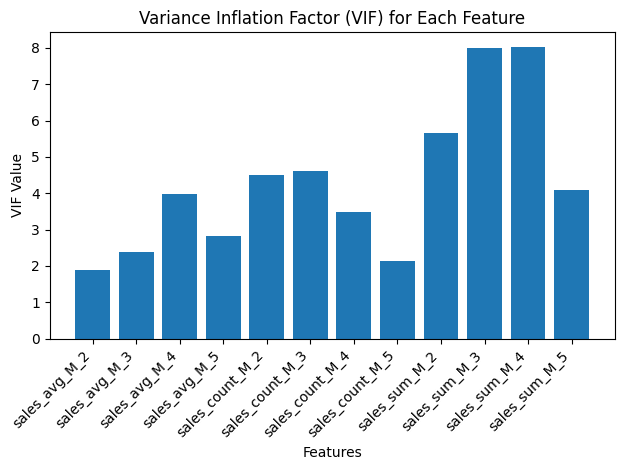

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Correct column names based on the output of sample_set_df.columns
X = sample_set_df[['sales_avg_M_2', 'sales_avg_M_3', 'sales_avg_M_4', 'sales_avg_M_5',
             'sales_count_M_2', 'sales_count_M_3', 'sales_count_M_4', 'sales_count_M_5',
             'sales_sum_M_2', 'sales_sum_M_3', 'sales_sum_M_4', 'sales_sum_M_5']]
y = sample_set_df['CLV_3M']

# Fit the linear regression model
model = reg_fit

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

X_name=['sales_avg_M_2', 'sales_avg_M_3', 'sales_avg_M_4', 'sales_avg_M_5',
             'sales_count_M_2', 'sales_count_M_3', 'sales_count_M_4', 'sales_count_M_5',
             'sales_sum_M_2', 'sales_sum_M_3', 'sales_sum_M_4', 'sales_sum_M_5']


#Plot the VIF for each feature using barchart
plt.bar(vif_data["feature"], vif_data["VIF"])
plt.xlabel('Features')
plt.ylabel('VIF Value')
plt.title('Variance Inflation Factor (VIF) for Each Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##2. Complexity of data process completeness

Before loading data into a linear regression model, significant preprocessing is required, such as splitting the data into specific time periods (e.g., M_1, M_2, M_3, M_4, M_5) and calculating aggregates like mean, count, and sum of sales for each period. This manual process increases the workload and introduces potential human errors, making it time-consuming and complex.

In contrast, BG/NBD and Gamma-Gamma models simplify data processing by using packages that automatically calculate key metrics (e.g., frequency, recency, and monetary value) from raw transactional data, reducing both effort and the risk of errors while ensuring data process completeness.
____



##3. Providing limited prediction
The linear regression model is only trained to provide one single outcome, the sum of the transaction amount for each customer (sales_sum) in period M_1, providing limited prediction for finding the highest-value customer. Also, if we would like to find out other features, such as purchasing frequency, for predicting the customer lifetime value, a new model is needed to train.

While BG/NBD and Gamma-Gamma models, provide a more comprehensive view of customer behaviour. In addition to predicting the future transaction amount for each customer in M_1 period, they can also forecast the purchasing frequency and the probability of being alive for each customer without training a new model to do these predictions but also provide more useful information for businesses. This makes them a more informative tool for customer lifetime value (CLV) prediction compared to linear regression.

___



##4. Negative Customer Lifetime Value (CLV) predictions


When the linear regression model is used to predict the CLV for each customer in the M_1 period, negative values are generated. Since the CLV for the linear regression model is  the total transaction amount, it is not reasonable if negative.

Although the total transaction amount of each customer is also treated as the prediction of CLV in BG/NBD and Gamma-Gamma models, there is no negative output when using this method.

Therefore, it shows that the linear regression model might not be the best model to do the prediction.

___

##5. Not providing enough information to find the most valuable customer
In this case study, the original solution does not provide any future predictions for identifying the most valuable customer, which is the primary purpose of conducting this prediction.
___

# Extension solution - BG/NBD with Gamma Gamma model

Because some of the potential weekness are found in the orinigal, thus a new model (**BG/NBD with gamma gamma model**) have proposed to predicts ​how much money customers will spend in the future (predicted Customer life value **CLV**) by analyzing their past shopping behavior.

The extension solution can answer the following question:
1. How often will customers buy again?
2. How much will they spend each time?
3. What are their corresponding **predicted CLV**?

In the extension solution, the prediction period will set as 3 month (this is the prediction period of orinigal solution also), but note that this can change in the real life business.

## Method

Step 1: ​Prepare the Data:

- Summarizes raw transaction data into 4 key variable for each customer:
  - ​**Recency**
  - **​Frequency**
  - **Monetary Value**
  - **​Tenure** **T**

​Step 2: Predict Purchase Frequency (**BG/NBD Model**):
- Uses historical data to predict how often customers will buy in the next 90 days (**Predicted frequency**).
​

Step 3: ​Predict Spending per Purchase (**Gamma-Gamma Model**):
- Estimates how much customers will spend each time they buy (**Predicted Monetary Value**).

Step 4: ​Calculate Customer Lifetime Value (CLV):
- Combines the two predictions to estimate total future revenue per customer over 3 months. (**Predicted CLV**)



In [ ]:
# This code is to import necessary Python libraries and modules used in the BG/NBD with Gamma Gamma model

!pip install lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_frequency_recency_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.9 MB/s eta 0:00:00


## Step 1: ​Prepare the Data

In [ ]:
# We used the data set in the orinigal solution but using hole data time range

df = pd.read_excel(file_name, sheet_name='Online Retail')
df = df.loc[df['Quantity'] > 0] # Remove quantities that are less than 0 (possibly returned items)
df = df[pd.notnull(df['CustomerID'])] # Remove blank customer IDs
df['Sales'] = df['Quantity'] * df['UnitPrice'] # Create a Sales Revenue Column

In [ ]:
# Compute summary metrics (Recency, Frequency, Monetary, and Tenure) from transaction data.
# The `summary_data_from_transaction_data` function transforms raw transaction data into a structured dataset,
# which is ready for direct use in model fitting.

df_rfmt = summary_data_from_transaction_data(transactions = df,
                                         customer_id_col = 'CustomerID',
                                         datetime_col = 'InvoiceDate',
                                         monetary_value_col = 'Sales')
df_rfmt.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


**Note**
- The unit of recency and T is day.


- T is defined as the age of the customer. This is equal to the duration between a customer’s first purchase and the end of the period under study.

- Frequency is defined as the repeat number of transactions, for example if a customer has made 5 purchases, their frequency will be 4.

- monteetary value is define as the average buying value per transaction.

- In the above data frame, some customers have a frequency of 0, This occurs when a customer has only made ​one transaction during the observed period. In this cases, both frequency and recency are set to 0, and the monetary value is also 0 because there is no repeat behavior to analyze.

- While customers with only one transaction (frequency = 0) are not used to predict Customer Lifetime Value (CLV), they are still included in the BG/NBD model to ensure a comprehensive and accurate fit.

## Stpe 2: Predict Purchase Frequency (**BG/NBD Model**)

In [ ]:
# Fit the BG/NBD model using the customer's frequency, recency, and tenure T data from the `df_rfmt` dataset.

model = BetaGeoFitter(0)
model.fit(df_rfmt['frequency'],
        df_rfmt['recency'],
        df_rfmt['T'])
model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


**Medthod and Result Explanation**

The BG/NBD model separate two main distributions to capture customer behavior, one is ​**Gamma Distribution (parameters: `r` and `α`)**, which models the frequency of customer purchases. The second one is  ​**Beta Distribution (parameters: `a` and `b`)**, models the probability that a customer is still alive.

| Parameter | Description                                        | In our case                                                |
|-----------|----------------------------------------------------|------------------------------------------------------------|
| r         | Models variance of purchase frequency             | `r = 0.826433`, relative low ; some buy often, while others buy very little |
| α         | Controls the customer's average buying frequency    | `α = 68.890678`, relative High α; customers buy less frequently             |
| a         | Represents how quickly customers stop buying        | `a = 0.003443`, relative Low a; customers are unlikely to stop buying quickly|
| b         | Represents how likely customers are to stay active    | `b = 6.749363`, relative High b; most customers are likely to stay active    |



<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

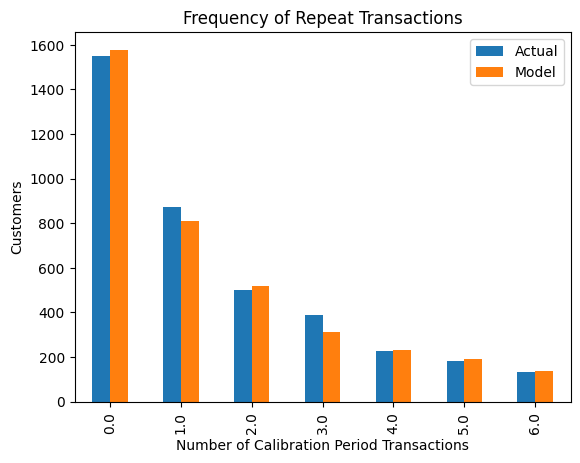

In [ ]:
# Set the Calibration period as 2010-12-01 to 2011-09-30
# Plot the frequency of repeat transactions during the calibration period,
# comparing actual customer behavior (blue bars) with model predictions (orange bars).
import datetime as dt
end_date_cal = df['InvoiceDate'].max() - dt.timedelta(days=60)
plot_period_transactions(model)

**Graph Explanination**
- The graph helps us ​check if the model is accurate by comparing the  ​actual customer behavior (blue bars) and ​model predictions (orange bars) for repeat transactions.

- The model predictions (orange bars) are ​close to the actual values and thus the fitting performance of the model is good enough.

In [ ]:
# Predicting the number of purchases in the next 90 days for all customers.
df_rfmt['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(90,
                                                                                      df_rfmt['frequency'],
                                                                                      df_rfmt['recency'],
                                                                                      df_rfmt['T'])

# Droped the NA predicted_purchases
# The NA may occur if any of the input columns (frequency, recency, or T) have ​NA values, the model cannot make a prediction
df_rfmt.dropna(subset=['predicted_purchases'], inplace=True)
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12346.0,0.0,0.0,325.0,0.000000,0.188812
12347.0,6.0,365.0,367.0,599.701667,1.408759
12348.0,3.0,283.0,358.0,301.480000,0.805911
12349.0,0.0,0.0,18.0,0.000000,0.855637
12350.0,0.0,0.0,310.0,0.000000,0.196286
...,...,...,...,...,...
18280.0,0.0,0.0,277.0,0.000000,0.215011
18281.0,0.0,0.0,180.0,0.000000,0.298794
18282.0,1.0,119.0,126.0,77.840000,0.842753


**Remark:**

- The predicted_purchases are the number of purchases of customers will buy in the next 90 days.
- The predicted_purchases will then used to get the predicted CLV.

## Step 3: ​Predict Spending per Purchase (Gamma-Gamma Model)

In [ ]:
# Fitting the GammaGamma model
# Make sure the moetary_value is greater than 0 before fitting the GammaGamma model
# (i.e. monetary_value = 0, those frequency will also = 0, they are removed)

df_rfmt = df_rfmt[df_rfmt['monetary_value'] > 0]
gg_model = GammaGammaFitter()
gg_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value']).summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.103523,0.111998,1.884007,2.323039
q,3.449907,0.139042,3.177385,3.722429
v,485.570938,42.595555,402.083650,569.058225


**Medthod and Result Explanation**

The ​**Gamma-Gamma model** is used to predict how much customers spend on average. (predicted monetary)

**Parameters of the Gamma-Gamma Model**

| Parameter | Description                                                  |
|-----------|--------------------------------------------------------------|
| P         | Describes variance of individual customers' monetary value.  |
| q         | Describes variance of monetary value across all customers.   |
| V         | Controls the average monetary value across all customers.    |

**Results**  
The model analyzed 2,698 customers.  
- ​**p = 2.10**
- ​**q = 3.45**
- ​**v = 485.57**

In [ ]:
df_rfmt['pred_monetary'] = gg_model.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary
CustomerID,,,,,,
12347.0,6.0,365.0,367.0,599.701667,1.408759,569.988807
12348.0,3.0,283.0,358.0,301.480000,0.805911,333.762672
12352.0,6.0,260.0,296.0,368.256667,1.682315,376.166864
12356.0,2.0,303.0,325.0,269.905000,0.645367,324.008941
12358.0,1.0,149.0,150.0,683.200000,0.750395,539.930643
...,...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,1.664270,474.369525
18273.0,2.0,255.0,257.0,76.500000,0.780057,201.781295
18282.0,1.0,119.0,126.0,77.840000,0.842753,260.275833


## Step 4: ​Calculate Customer Lifetime Value (CLV)

In [ ]:
# Predicting the future 3 month CLV.
df_rfmt['pred_3month_CLV'] = df_rfmt['predicted_purchases']*df_rfmt['pred_monetary']
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,pred_3month_CLV
CustomerID,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,1.408759,569.988807,802.976798
12348.0,3.0,283.0,358.0,301.480000,0.805911,333.762672,268.982959
12352.0,6.0,260.0,296.0,368.256667,1.682315,376.166864,632.831326
12356.0,2.0,303.0,325.0,269.905000,0.645367,324.008941,209.104598
12358.0,1.0,149.0,150.0,683.200000,0.750395,539.930643,405.161078
...,...,...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,1.664270,474.369525,789.478815
18273.0,2.0,255.0,257.0,76.500000,0.780057,201.781295,157.400999
18282.0,1.0,119.0,126.0,77.840000,0.842753,260.275833,219.348197


**Result Explaination**

- Finally, we can predict the **furture 3 month CLV** by the product of `predicted_purchases `and `pred_monetary`
- And this time no negative CLV will predicted, but linear solution in orinigal solution does.

**Remark**: Since the Gamma-Gamma model requires both the frequency and monetary value to be at least 1, customers with only one transaction will be excluded in the prediction which same with the orinigal solution.

## Strength of our proposed model: Comparing BGNBD with gamma gamma model and linear model peformance



**Introduction:**
For the above, we already have the Actual vs. Predicted plot of linear model in orinigal and the plot is generate by using the history data to predict the corresponding 30% M1 sales sum (CLV). We would like to generate the Actual vs. Predicted plot of BG/NBD + Gamma-Gamma model in this part also, and to compare their performance in terms of accuracy.

**Method:**
We tested how well the ​BG/NBD + Gamma-Gamma model predicts customer CLV over a 60-day period (Sep 30 – Nov 30, 2011) which is same with the M1 period in orinigal solution.

- Step 1: ​Train the Models and predict the observation
  - Used data from before Sep 30, 2011 (same with the period of featuers in linear model) to train the models.
  - Predicted purchases and spending for the next 60 days (Sep 30 – Nov 30, 2011)
  - The prediction method is similar to predicted future 3 month customer CLV,

- Stpe 2:
  - Merged predictions with actual sales data from the 60-day period to see how accurate the model was.





In [ ]:
# Define the start date for the calibration period
M1_start_date = pd.to_datetime('2011-09-30 00:00:00')

# Filter the dataset for the calibration period
df_Cal = df[(df['InvoiceDate'] < M1_start_date)]

# Summarize transaction data for the calibration period
df_rfmt_cal = summary_data_from_transaction_data(
    transactions=df_Cal,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='Sales'
)

# Fit the BG/NBD model
model_cal = BetaGeoFitter(penalizer_coef=1)
model_cal.fit(
    df_rfmt_cal['frequency'],
    df_rfmt_cal['recency'],
    df_rfmt_cal['T']
)

# Predict the number of purchases in the next 60 days
df_rfmt_cal['predicted_purchases'] = model_cal.conditional_expected_number_of_purchases_up_to_time(
    60, df_rfmt_cal['frequency'], df_rfmt_cal['recency'], df_rfmt_cal['T']
)

# Drop rows with missing values and filter out negative monetary values
df_rfmt_cal.dropna(inplace=True)
df_rfmt_cal = df_rfmt_cal[df_rfmt_cal['monetary_value'] > 0]

# Fit the Gamma-Gamma model
gg_model_cal = GammaGammaFitter()
gg_model_cal.fit(df_rfmt_cal['frequency'], df_rfmt_cal['monetary_value'])

# Predict the monetary_value
df_rfmt_cal = df_rfmt_cal[df_rfmt_cal['monetary_value'] > 0]
gg_model2 = GammaGammaFitter()
gg_model2.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])
df_rfmt_cal['pred_monetary'] = gg_model2.conditional_expected_average_profit(
        df_rfmt_cal['frequency'],
        df_rfmt_cal['monetary_value'])

# Predicting Customer Lifetime Value (CLV)
df_rfmt_cal
df_rfmt_cal['predicted CLV'] = df_rfmt_cal['predicted_purchases']* df_rfmt_cal['pred_monetary']

# Rename columns for clarity
df_rfmt_cal.rename(columns={
    'predicted_purchases': 'predicted freq of M1 period',
    'monetary_value': 'pred monetary value of M1 period',
    'predicted CLV': 'predicted sales sum of M1 (predicted CLV)'
}, inplace=True)

# Display the resulting DataFrame
df_rfmt_cal

,frequency,recency,T,pred monetary value of M1 period,predicted freq of M1 period,pred_monetary,predicted sales sum of M1 (predicted CLV)
CustomerID,,,,,,,
12347.0,4.0,238.0,296.0,519.767500,0.801377,496.574148,397.942948
12348.0,3.0,283.0,287.0,301.480000,0.632484,333.762672,211.099407
12352.0,5.0,224.0,225.0,379.562000,1.267941,386.619472,490.210488
12356.0,1.0,80.0,254.0,481.460000,0.277885,446.733932,124.140860
12359.0,2.0,142.0,260.0,1474.115000,0.482167,1085.042801,523.171877
...,...,...,...,...,...,...,...
18263.0,1.0,97.0,181.0,503.800000,0.376097,457.054218,171.896730
18265.0,1.0,86.0,87.0,312.960000,0.690206,368.892919,254.612213
18272.0,3.0,133.0,175.0,488.876667,0.985702,468.753003,462.050929


In [ ]:
# Recall our actual CLV (Sale sum of M1 is in the CLV_3M of sample_set_df)

sample_set_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.000000,0.000,77183.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,0.00
5.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.000000,367.000,227.440000,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,0.00
NaN,0.000000,0.000,334.400000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,0.00
14.0,316.250000,0.000,312.362000,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.000000,0.000,180.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,180.60,0.00,18280.0,0.00
NaN,0.000000,80.820,0.000000,0.00,0.0,1.0,0.0,0.0,0.00,80.82,0.00,0.00,18281.0,0.00
NaN,100.210000,0.000,0.000000,0.00,1.0,0.0,0.0,0.0,100.21,0.00,0.00,0.00,18282.0,0.00
9217.0,92.696667,131.170,105.966667,0.00,3.0,4.0,3.0,0.0,278.09,524.68,317.90,0.00,18283.0,766.21


In [ ]:
# Merge the data set with "predicted sales sum of M1 (predicted CLV)" and "actual CLV (Sales sum) of M1"

# Reset the index of df_rfmt_cal and convert CustomerID to string
df_rfmt_cal_resetindex = df_rfmt_cal.reset_index()
df_rfmt_cal_resetindex['CustomerID'] = df_rfmt_cal_resetindex['CustomerID'].astype(str)

# Ensure the response_df has CustomerID as string
sample_set_df['CustomerID'] = sample_set_df['CustomerID'].astype(str)

# Merge the two DataFrames on 'CustomerID' (inner join)
combined_df = df_rfmt_cal_resetindex.merge(
    sample_set_df, on='CustomerID', how='inner'
)

# Select the relevant columns
combined_df.rename(columns={
    'CLV_3M': 'actual sales sum of M1 (actual CLV)',
}, inplace=True)

combined_df = combined_df[['CustomerID', 'predicted sales sum of M1 (predicted CLV)', 'actual sales sum of M1 (actual CLV)']]
combined_df

,CustomerID,predicted sales sum of M1 (predicted CLV),actual sales sum of M1 (actual CLV)
0,12347.0,397.942948,1294.32
1,12348.0,211.099407,0.00
2,12352.0,490.210488,311.73
3,12356.0,124.140860,58.35
4,12359.0,523.171877,2876.85
...,...,...,...
2107,18263.0,171.896730,401.76
2108,18265.0,254.612213,0.00
2109,18272.0,462.050929,604.25
2110,18273.0,99.673788,0.00


In [ ]:
# Since the predicted data in orinigal solution is just 30% of all data, so just select the same number of data point
sampled_df = combined_df.sample(n=len(df_Y), random_state=2025)
sampled_df

,CustomerID,predicted sales sum of M1 (predicted CLV),actual sales sum of M1 (actual CLV)
1498,16573.0,125.695382,0.00
1466,16475.0,150.164024,0.00
399,13458.0,1221.028891,1383.63
379,13397.0,294.002977,0.00
1318,16036.0,174.156709,0.00
...,...,...,...
39,12444.0,625.539458,1815.65
1422,16353.0,693.946745,2376.30
519,13782.0,120.769911,424.07
683,14226.0,194.510810,337.02


**Note**

We can see that the above predicted CLV have no negative value, so we will use the actual-predicted plot with no negative predicted CLV value in linear regression to compare with the above plot.


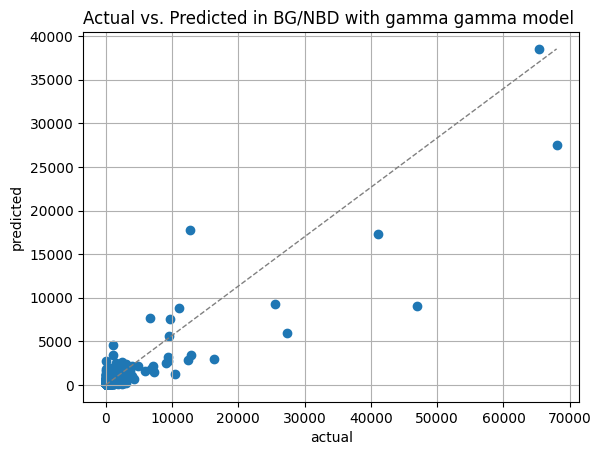

In [ ]:
plt.scatter(sampled_df['actual sales sum of M1 (actual CLV)'], sampled_df['predicted sales sum of M1 (predicted CLV)'])
plt.plot(
    [0, max(sampled_df['actual sales sum of M1 (actual CLV)'])],
    [0, max(sampled_df['predicted sales sum of M1 (predicted CLV)'])],
    color='gray',
    lw=1,
    linestyle='--'
)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Actual vs. Predicted in BG/NBD with gamma gamma model ')
plt.grid()

plt.show()

In [ ]:
print('MAE: %0.4f' % median_absolute_error(
    y_true=sampled_df['actual sales sum of M1 (actual CLV)'],
    y_pred=sampled_df['predicted sales sum of M1 (predicted CLV)']
))

MAE: 229.4651


**Compare the MAE of linear and BG/NBD with gamma gamma**

- Linear MAE: 250.6356 \
- BG/NBD with gamma gamma MAE: 229.4651
- Although their plot is similar but BG/NBD with gamma gamma will perform slightly better if we use MAE.



**Generate the actual-predicted plot by removing those actual CLV equal 0 and log the actual predicted value again.**

We find there there is some actual CLV value is 0. Since our target is to find those actually high CLV customer, so remove those CLV=0 can compare their performance in predicting the high CLV, and since there is some outliners, we would further log the predict CLV and actual CLV and plot the graph again.

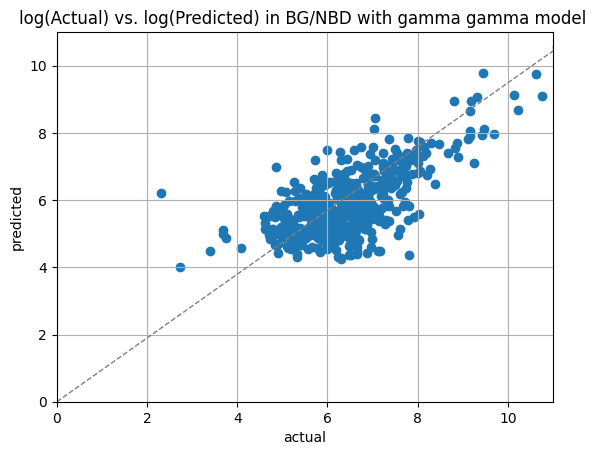

In [ ]:
# Filter out rows where actual CLV or predicted CLV is zero

sampled_df = sampled_df[
    (sampled_df['actual sales sum of M1 (actual CLV)'] > 0) &
    (sampled_df['predicted sales sum of M1 (predicted CLV)'] > 0)
]

# Create the scatter plot with the filtered data
plt.scatter(np.log(sampled_df['actual sales sum of M1 (actual CLV)']), np.log(sampled_df['predicted sales sum of M1 (predicted CLV)']))
plt.plot(
    [0, max(np.log(sampled_df['actual sales sum of M1 (actual CLV)']))],
    [0, max(np.log(sampled_df['predicted sales sum of M1 (predicted CLV)']))],
    color='gray',
    lw=1,
    linestyle='--'
)
plt.xlim(0, 11)
plt.ylim(0, 11)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('log(Actual) vs. log(Predicted) in BG/NBD with gamma gamma model ')
plt.grid()

plt.show()

**Result**

While the ​BG/NBD wiith Gamma-Gamma model and the ​original linear regression model show similar overall accuracy, there’s a key difference when focusing on ​high-value customers (those with actual CLV > 0).

By removing customers with ​zero CLV, we see that the proposed ​BG/NBD with Gamma-Gamma model performs ​significantly better than the linear regression model. This means our proposed model is more effective at predicting the behavior of ​high-value customers, who are the focus of our project.

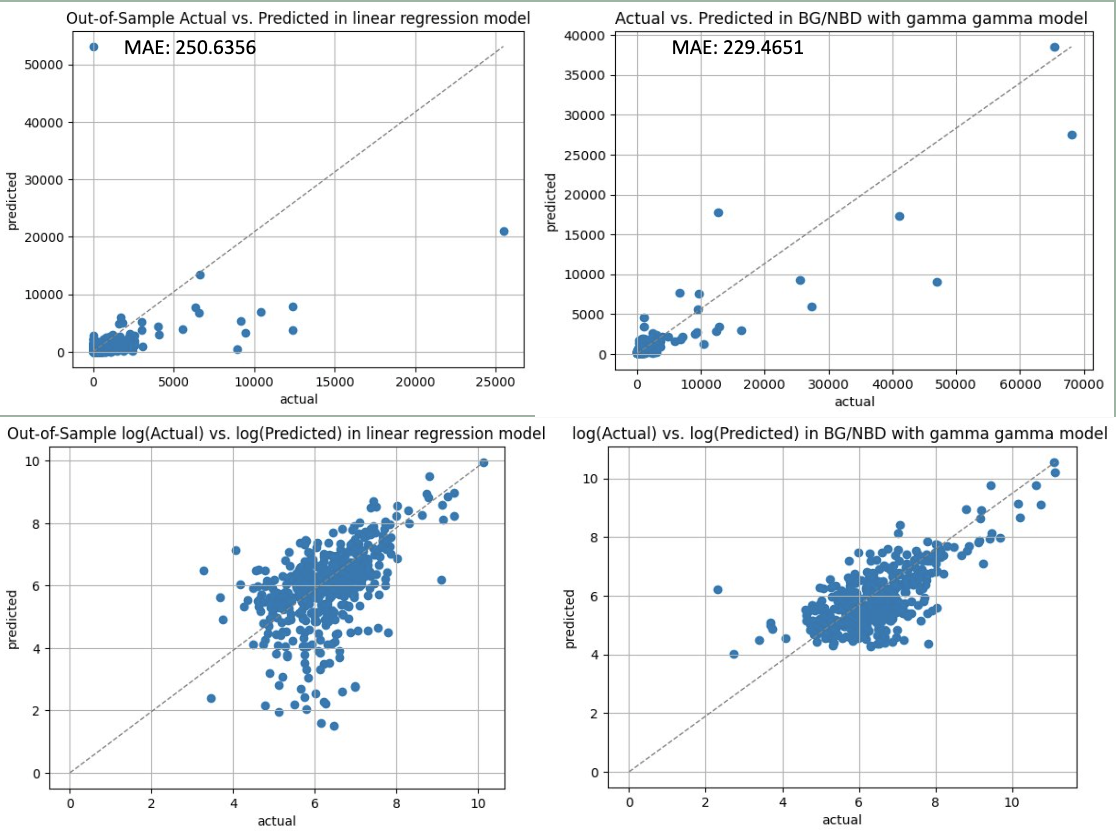

## Description of methodology used and tools in BG/NBD with gamma gamma model

1. **`lifetimes` library**: provides tools for using BG/NBD and gamma gamma to predict CLV. Here’s a breakdown of the key functions used in above code.
  -  `summary_data_from_transaction_data`: Prepares the data for the BG/NBD and Gamma-Gamma models
  - `BetaGeoFitter`: Fits the ​BG/NBD model.
  - `GammaGammaFitter`: Fits the ​**Gamma-Gamma model**.
  - `plot_period_transactions`: Plots the frequency of repeat transactions during a calibration period to validates the accuracy of the BG/NBD model.
  - `plot_frequency_recency_matrix`: Visualizes expected future purchases based on ​**frequency** and ​**recency**.  


2. ​**BG/NBD Model**:  
   - Predicts ​**how often** customers will buy in the future.  
3. ​**Gamma-Gamma Model**:  
   - Predicts ​**how much** customers will spend per transaction.  
4. ​**Combined Prediction**:  
   - ​**Predicted CLV = Predicted frequency × Predicted monetary value**.  
  



# Extension solution - K-means clustering

Since the original solution did not give us the targeted customer group directly, we choose to use K-means clustering to help us find the targeted customer group.

**Steps:**

1. Data Preparation and Standardization:
Extracted two essential features: predicted_purchases and pred_monetary.
Standardized the data to ensure fair clustering and minimize the effect of different scales.

2. Determination of Optimal Cluster Number (k):
Utilized the Elbow Method to determine the optimal number of clusters.
The optimal number of clusters was identified using the KneeLocator based on the elbow point and the maximum silhouette score.

3. Clustering and Analysis:
Applied K-means clustering with the optimal k value.
Computed cluster centers and summarized each cluster's average predicted purchases, average predicted monetary value, and the total customer count.
Sorted clusters based on their total predicted value to highlight the most valuable groups.

4. Identification of High-Value Customer Segments:
Selected the top 2 high-value clusters based on average predicted purchases and average predicted monetary values.
Extracted customer IDs from these high-value clusters for targeted marketing or personalized strategies.

5. Visualization:
Visualized the clustering results using a scatter plot, highlighting cluster centers and high-value clusters.
Created a heatmap to illustrate the distinguishing characteristics of each cluster.

**Key Findings:**

The top two high-value clusters demonstrate higher predicted purchases and monetary values, indicating potential for maximizing customer lifetime value.
Customers in these clusters can be prioritized for retention strategies, exclusive promotions, and loyalty programs.


## Step 1: Find the optimal k

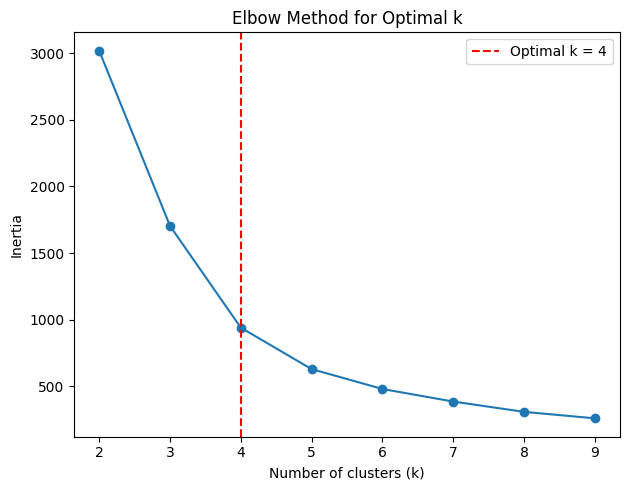

In [ ]:
!pip install kneed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import seaborn as sns

# Extract the two columns needed
X = df_rfmt[['predicted_purchases', 'pred_monetary']].copy()

# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 1: Use the Elbow Method to find the optimal number of clusters
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Automatically detect the elbow point
kneedle = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
optimal_k_elbow = kneedle.elbow
plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k = {optimal_k_elbow}')
plt.legend()
plt.tight_layout()
plt.show()


**Result**

The elbow method plot indicates that the optimal number of clusters (k) for the data is 4.

##  Step 2: Export the clusters summary

In [ ]:
# Perform clustering using the determined optimal k (using Elbow Method)
optimal_k = optimal_k_elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_rfmt['cluster'] = kmeans.fit_predict(X_scaled)

# Compute cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_summary = pd.DataFrame(cluster_centers,
                              columns=['avg_predicted_purchases', 'avg_pred_monetary'])
cluster_summary['count'] = df_rfmt.groupby('cluster').size().values
cluster_summary['total_value'] = cluster_summary['avg_predicted_purchases'] * cluster_summary['avg_pred_monetary']
cluster_summary = cluster_summary.sort_values('total_value', ascending=False).reset_index().rename(columns={'index': 'cluster'})

print("Cluster Summary:")
print(cluster_summary)


Cluster Summary:
   cluster  avg_predicted_purchases  avg_pred_monetary  count   total_value
0        1                 0.599739       78051.285456      1  46810.366377
1        3                19.590359         516.419579      7  10116.844977
2        2                 3.859390         618.981990    307   2388.893016
3        0                 1.078574         402.911190   2475    434.569454


##  Step 3: Predict the targeted customer IDs

In [ ]:
# Identify the top two highest-value clusters
top_n = 2  # Adjust this value to select more high-value clusters if necessary
high_value_clusters = cluster_summary.iloc[:top_n]['cluster'].tolist()
print(f"\nTop {top_n} high-value clusters are: {high_value_clusters} with average predicted purchases and monetary values:")

for i, cluster in enumerate(high_value_clusters):
    avg_predicted_purchases = cluster_summary.iloc[i]['avg_predicted_purchases']
    avg_pred_monetary = cluster_summary.iloc[i]['avg_pred_monetary']
    print(f"Cluster {cluster}: Avg Predicted Purchases = {avg_predicted_purchases:.2f}, Avg Monetary Value = {avg_pred_monetary:.2f}")

# Extract high-value customer IDs
high_value_customers = df_rfmt[df_rfmt['cluster'].isin(high_value_clusters)]
print("\nHigh-value customer IDs:")
print(high_value_customers)


Top 2 high-value clusters are: [1, 3] with average predicted purchases and monetary values:
Cluster 1: Avg Predicted Purchases = 0.60, Avg Monetary Value = 78051.29
Cluster 3: Avg Predicted Purchases = 19.59, Avg Monetary Value = 516.42

High-value customer IDs:
            frequency  recency      T  monetary_value  predicted_purchases  \
CustomerID                                                                   
12748.0         113.0    373.0  373.0      298.360885            23.175061   
12971.0          70.0    369.0  372.0      159.211286            14.452417   
13089.0          65.0    367.0  369.0      893.714308            13.524270   
14606.0          88.0    372.0  373.0      135.890114            18.084835   
14911.0         131.0    372.0  373.0     1093.661679            26.839684   
15311.0          89.0    373.0  373.0      677.729438            18.288586   
16446.0           1.0    205.0  205.0   168469.600000             0.599739   
17841.0         111.0    372.0  37

##  Step 4: Visualization

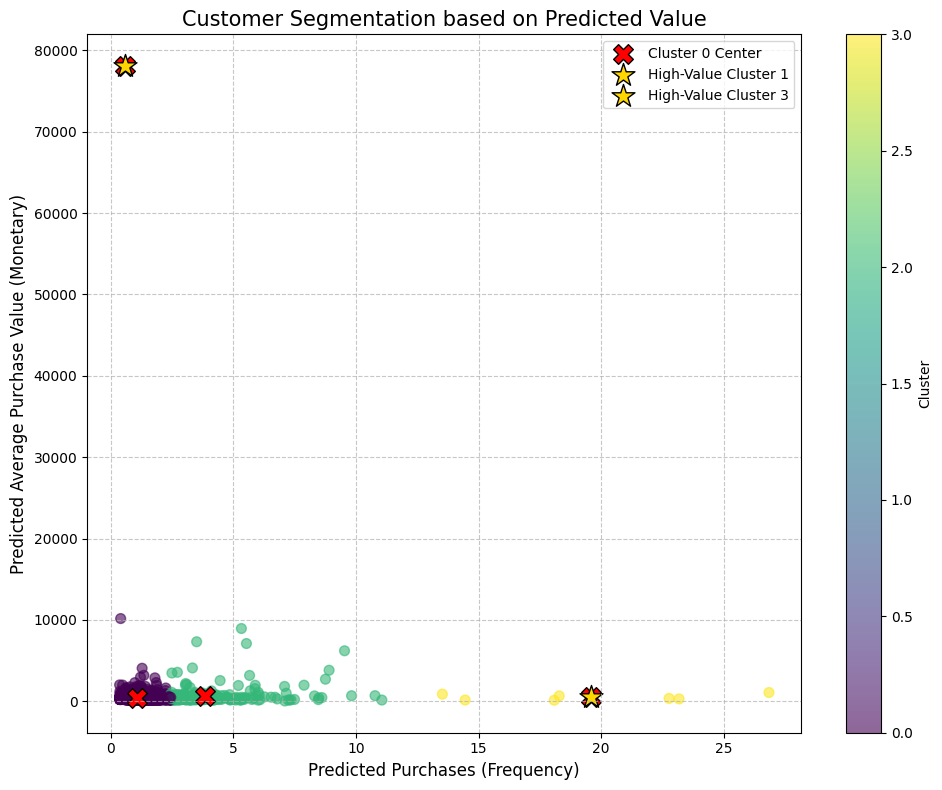

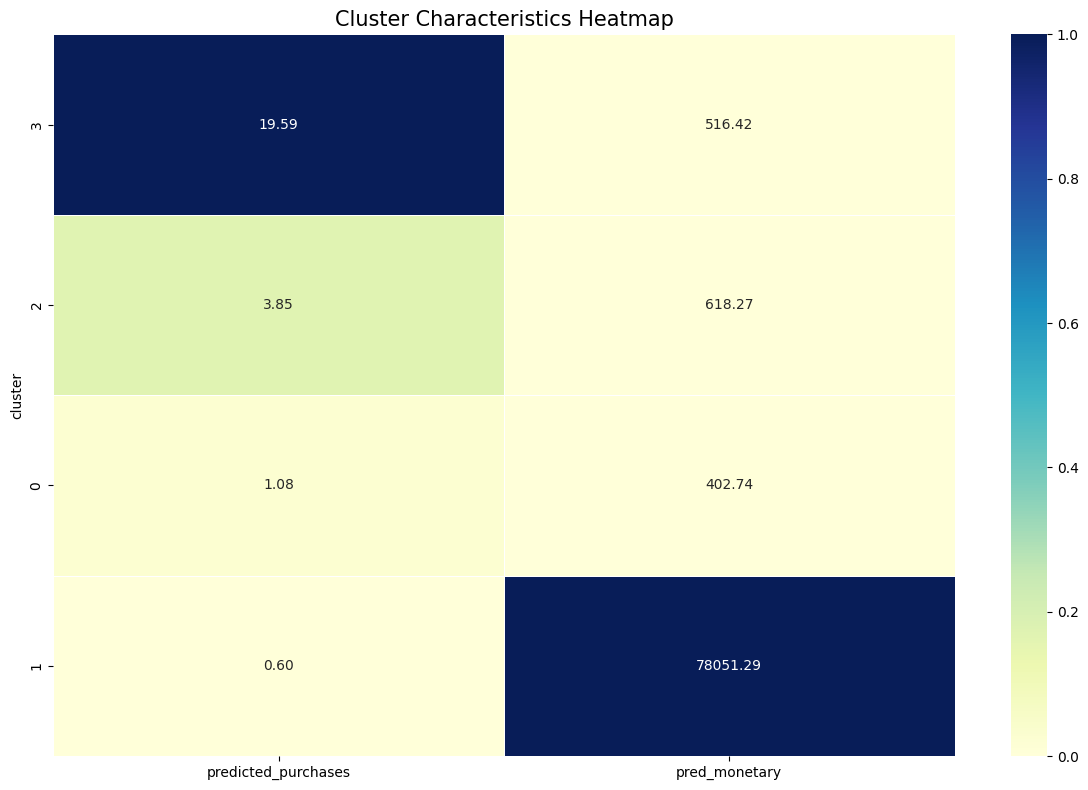

In [ ]:
# Visualization: Scatter plot of clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_rfmt['predicted_purchases'],
                      df_rfmt['pred_monetary'],
                      c=df_rfmt['cluster'],
                      cmap='viridis',
                      alpha=0.6,
                      s=50)

# Mark cluster centers
for i, center in enumerate(cluster_centers):
    plt.scatter(center[0], center[1], c='red', marker='X', s=200, edgecolors='black',
                label=f'Cluster {i} Center' if i == 0 else "")

# Mark high-value clusters
for cluster in high_value_clusters:
    high_value_center = cluster_centers[int(cluster)]
    plt.scatter(high_value_center[0], high_value_center[1], c='gold', marker='*', s=300, edgecolors='black',
                label=f'High-Value Cluster {cluster}')

plt.title('Customer Segmentation based on Predicted Value', fontsize=15)
plt.xlabel('Predicted Purchases (Frequency)', fontsize=12)
plt.ylabel('Predicted Average Purchase Value (Monetary)', fontsize=12)
plt.colorbar(scatter, label='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap of cluster characteristics
plt.figure(figsize=(12, 8))
pivot_data = df_rfmt.groupby('cluster')[['predicted_purchases', 'pred_monetary']].mean().reset_index()
pivot_data = pivot_data.sort_values(by='predicted_purchases', ascending=False)

# Standardize data for visualization
heatmap_data = pivot_data.set_index('cluster')
heatmap_data_scaled = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())

sns.heatmap(heatmap_data_scaled, annot=heatmap_data, fmt='.2f', cmap='YlGnBu', linewidths=.5)
plt.title('Cluster Characteristics Heatmap', fontsize=15)
plt.tight_layout()
plt.show()


**Result**

1.The above graph is to visualized the clustering results using a scatter plot, highlighting cluster centers and high-value clusters.

2.And created a heatmap to illustrate the distinguishing characteristics of each cluster.

##  Strength of our clustering results: Comparing the CLV of the k clusters

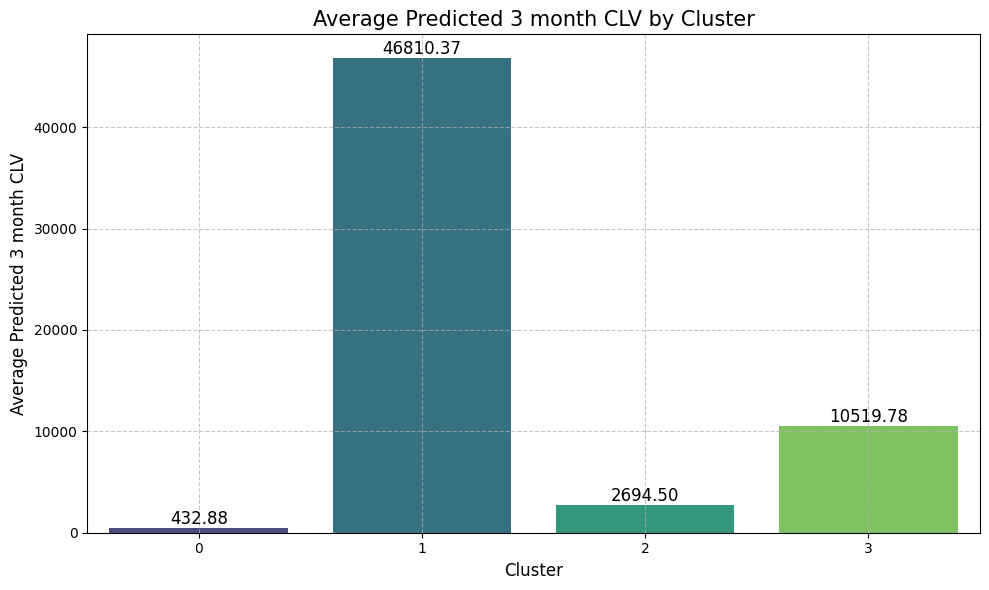

In [ ]:
# Visualization: bar chart


# Calculate average predicted CLV for each cluster
cluster_avg_clv = df_rfmt.groupby('cluster')['pred_3month_CLV'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='pred_3month_CLV', data=cluster_avg_clv, palette='viridis')
plt.title('Average Predicted 3 month CLV by Cluster', fontsize=15)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Predicted 3 month CLV', fontsize=12)
for index, row in cluster_avg_clv.iterrows():
    plt.text(index, row['pred_3month_CLV'], f'{row["pred_3month_CLV"]:.2f}', ha='center', va='bottom', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##  Final result

**Result**

The average predicted CLV of Cluster1 is significantly higher than those of other clusters, the second higer group is cluster 3. Thus we choose those as our targeted customer, as follow:

| Customer ID |
|-------------|
| 12748.0     |
| 12971.0     |
| 13089.0     |
| 14606.0     |
| 14911.0     |
| 15311.0     |
| 16446.0     |
| 17841.0     |


##  Description of methodology and function

1. **K-means clustering**:

 Initialization: Choose K initial centroids

 ​Assignment Step: Assign each data point to the nearest centroid using Euclidean distance

 Update Step: Recalculate centroids as the mean of points in each cluster

 Repeat until convergence (no centroid changes or maximum iterations reached)

2. **Elbow method**:

 Find the "elbow point" where adding more clusters yields diminishing return

3. **KneeLocator**:

 A Python utility from the kneed library that automates the detection of the optimal "elbow" or "knee" point in a curve, such as the SSE vs. K plot used in the Elbow Method. It eliminates the subjectivity of visually identifying the elbow and provides a data-driven approach.


# Conclusion

**Purpose:** find the targeted customer group​

​
**Original solution:** using linear model to predict the CLV in future three months​

​
**Drawback:**

1.not vary accurate (since there is a linear relationship between parameters)​

2.Complexity of data process completeness​

3.Negative CLV predictions in Linear Regression model​

4.Not providing future information to find CLV​

​
​
**Extension 1:** using BGNBD & gamma-gamma model to predict the frequency and monetary value in future three months​

​
**Advantage:**

1.more accurate​
              
2.more flexible (since linear model can only predict the future CLV on monthly basis, but BGNBD & gamma-gamma can predict the future CLV on daily basis) ​

​
**Extension 2:** using K-means clustering to find the targeted customer group​

​
**Advantage:** giving the customer IDs of the targeted customer group directly​

# Limitation

Although our model have higher predicted accuracy in our case, it's important to note that we just random select the customer to compare, to validate our results more thoroughly, we need to analyze future data over the next three months, and also our proposed model required a very strong statistics background that might be challenging for a general audience to understand, if you are interested in understanding the ​assumptions and fundamental principles of the BG/NBD model, the following reference paper provides a detailed explanation

# Reference

- Fader, P. S., Hardie, B. G., & Lee, K. L. (2005). “Counting your customers” the easy way: An alternative to the Pareto/NBD model. Marketing Science, 24(2), 275–284. https://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf

- lifetimes package — lifetimes 0.11.2 documentation. (n.d.). https://lifetimes.readthedocs.io/en/latest/lifetimes.html

- Data-Science-Analytics-AI-for-Business-the-Real-World-/All Resource files/Case Studies/Customer Life Time Value Modeling.ipynb at main · PacktPublishing/Data-Science-Analytics-AI-for-Business-the-Real-World-. (n.d.). https://github.com/PacktPublishing/Data-Science-Analytics-AI-for-Business-the-Real-World-/blob/main/All%20Resource%20files/Case%20Studies/Customer%20Life%20Time%20Value%20Modeling.ipynb
